In [10]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [3]:
def loop_wrapper(func):
    def loop_func(u0,Δx):
        u=u0+0
        for i in range(y.shape[1]-1):
            u=func(u,Δx)
        return u
    return loop_func

In [4]:
Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_JS)
WENO_JS_ref       = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z)
WENO_Z_ref        = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z_plus)
WENO_Z_plus_ref   = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_JS_M, mapa = mapa_Henrick)
WENO_JS_M_ref     = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z_M, mapa = mapa_Henrick)
WENO_Z_M_ref      = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)
Sim, Sim_step, DerivadaEspacial, Get_weights = create_simulation(API_Numpy, burgers_equation, WENO_Z_plus_M, mapa = mapa_Henrick)
WENO_Z_plus_M_ref = lambda u0, Δt, Δx, fronteira: Sim_step(u0, Δt, Δx, fronteira)

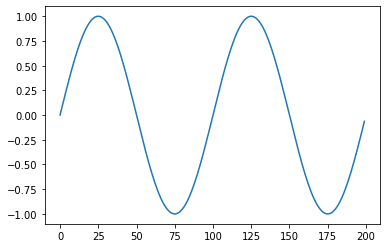

In [5]:
Δx = 0.01

f_test = lambda x: np.sin(2*pi*x) #np.exp(-0.05*(x**2))
plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [6]:
Δt  = 0.0001

n  = list(range(30, 30+1, 10)) # list(range(40, 40+1, 10))
Δx = n[:]

u_JS  = [] # WENO-JS
u_Z   = [] # WENO-Z
u_Zp  = [] # WENO-Z+
u_JSM = [] # WENO-JS com mapeamento (Henrick)
u_ZM  = [] # WENO-Z  com mapeamento (Henrick)
u_ZpM = [] # WENO-Z+ com mapeamento (Henrick)

n_ref  = []
Δx_ref = []
u_ref  = []

fator = 20 # Quantas vezes menor é a malha para a solução de referência

for k in range(len(n)):
    
    Δx[k] = 2/n[k]
    u_JS.append( f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_Z.append(  f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_Zp.append( f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_JSM.append(f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_ZM.append( f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    u_ZpM.append(f_test(tf.range(-1, 1, Δx[k], dtype=float_pres)))
    
    n_ref.append(n[k]*fator)
    Δx_ref.append(2/n_ref[k])
    u_ref.append(f_test(tf.range(-1, 1, Δx_ref[k], dtype=float_pres)))
    
for k in tf.range(len(n)):
    for t in tf.range(int(5/(9*Δt))):
        u_JS[k]  =        WENO_JS_ref(u_JS[k], Δt,     Δx[k], FronteiraPeriodica)
        u_Z[k]   =          WENO_Z_ref(u_Z[k], Δt,     Δx[k], FronteiraPeriodica)
        u_Zp[k]  =    WENO_Z_plus_ref(u_Zp[k], Δt,     Δx[k], FronteiraPeriodica)
        u_JSM[k] =     WENO_JS_M_ref(u_JSM[k], Δt,     Δx[k], FronteiraPeriodica)
        u_ZM[k]  =       WENO_Z_M_ref(u_ZM[k], Δt,     Δx[k], FronteiraPeriodica)
        u_ZpM[k] = WENO_Z_plus_M_ref(u_ZpM[k], Δt,     Δx[k], FronteiraPeriodica)
        u_ref[k] =        WENO_Z_ref(u_ref[k], Δt, Δx_ref[k], FronteiraPeriodica)


In [7]:
aux_x     = [  Δx,  Δx,   Δx,    Δx,   Δx,    Δx]
aux_y     = [u_JS, u_Z, u_Zp, u_JSM, u_ZM, u_ZpM]
aux_label = ["WENO-JS", "WENO-Z", "WENO-Z+", "WENO-JS (M)", "WENO-Z (M)", "WENO-Z+ (M)"]

x     = tf.range(-1, 1, aux_x[0][0], dtype=float_pres)
y     = aux_y[0][0]
label = tf.repeat([aux_label[0]], [len(aux_y[0][0])])

for i in tf.range(1, len(aux_x)):
    x = tf.concat([x, tf.range(-1, 1, aux_x[i][0], dtype=float_pres)], axis = 0)
    y = tf.concat([y, aux_y[i][0]], axis = 0)
    label = tf.concat([label, tf.repeat([aux_label[i]], [len(aux_y[i][0])])], axis = 0)
    
df = pd.DataFrame(
    {
        "x"     : x     ,
        "y"     : y     ,
        "label" : label
    }
)

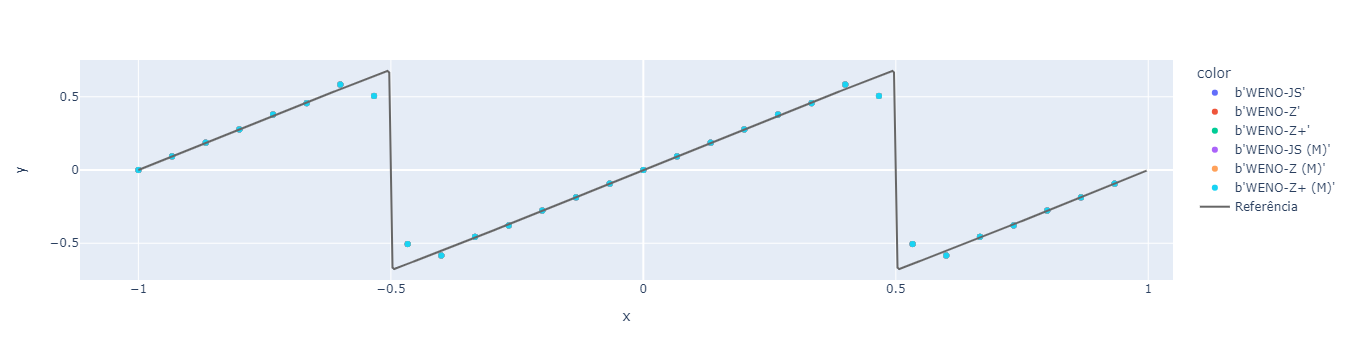

In [14]:
fig = ply_exp.scatter(
    data_frame = df    ,
    x          = x     ,
    y          = y     ,
    color      = label
)
fig.add_trace(
    ply_go.Scatter(
        x    = tf.range(-1, 1, Δx_ref[0], dtype=float_pres) ,
        y    = u_ref[0]                                     ,
        mode = "lines"                                      ,
        line = ply_go.scatter.Line(color="#666666")         ,
        name = "Referência"
    )
)
fig.show()

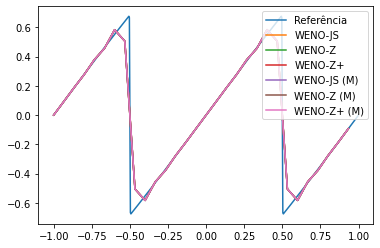

In [61]:
fig, axis = plt.subplots()
axis.plot(tf.range(-1, 1, Δx_ref[0], dtype=float_pres), u_ref[0], label="Referência")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),  u_JS[0], label="WENO-JS")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),   u_Z[0], label="WENO-Z")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),  u_Zp[0], label="WENO-Z+")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres), u_JSM[0], label="WENO-JS (M)")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres),  u_ZM[0], label="WENO-Z (M)")
axis.plot(tf.range(-1, 1,     Δx[0], dtype=float_pres), u_ZpM[0], label="WENO-Z+ (M)")
axis.legend()

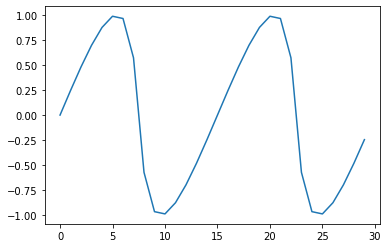

In [41]:
plt.plot(tf.gather(u_ref[0], tf.range(0, n[0])*fator))

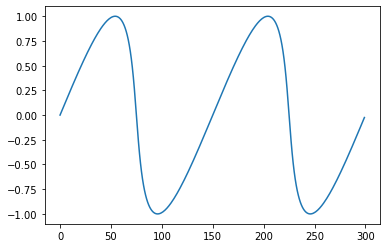

In [42]:
plt.plot(u_ref[0])

In [39]:

error = []

for k in tf.range(len(n)):
    
    aux = tf.gather(u_ref[k], tf.range(0, n[k])*fator)
    error.append(np.mean(np.abs(u[k]-aux)))
    

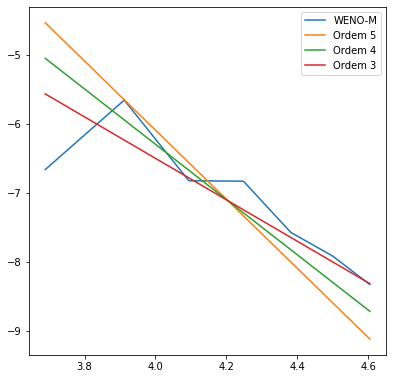

In [27]:
plt.figure(figsize=(6.4,6.4))

plt.plot(np.log(n),np.log(error),label='WENO-M')
plt.plot(np.log(n),-5*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 5')
plt.plot(np.log(n),-4*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 4')
plt.plot(np.log(n),-3*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 3')
plt.legend()

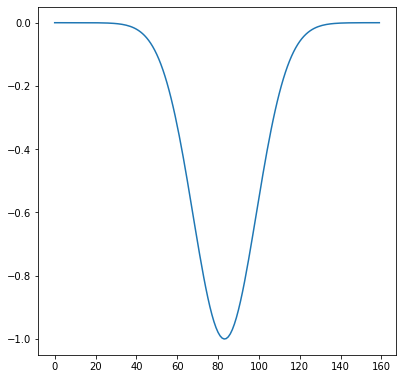

In [41]:
#plt.plot(net_u[0,0])
plt.figure(figsize=(6.4,6.4))
plt.plot(ref_u[0,0])
plt.savefig('imagens/ordem conv ds funcao.png')

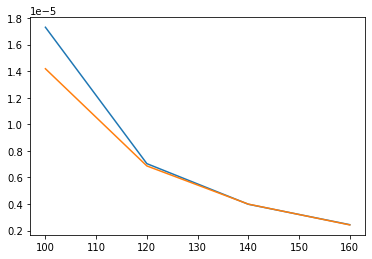

In [42]:
plt.plot(sizes,error1)
plt.plot(sizes,error2)

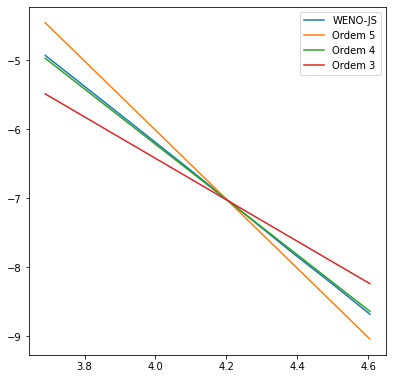

In [95]:
plt.figure(figsize=(6.4,6.4))

plt.plot(np.log(n),np.log(error),label='WENO-JS')
plt.plot(np.log(n),-5*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 5')
plt.plot(np.log(n),-4*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 4')
plt.plot(np.log(n),-3*(np.log(n)-np.mean(np.log(n)))+np.mean(np.log(error)),label='Ordem 3')
plt.legend()

In [ ]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [16]:
Δx_ref = 0.01

def f(x):
    return np.sin(np.pi*x)

def df(x):
    return np.pi*np.cos(np.pi*x)


In [17]:
Δx1 = Δx_ref
x1  = np.arange(-1, 1, Δx1)
x1  = np.expand_dims(x1,0)
u1  = f(x1)
du1 = df(x1)
y1=WENO_network(u1, Δx1)

print(u1.shape)

(1, 200)


In [18]:
Δx2 = Δx_ref/2
x2  = np.arange(-1, 1, Δx2)
x2  = np.expand_dims(x2,0)
u2  = f(x2)
du2 = df(x2)
y2=WENO_network(u2, Δx2)

print(u2.shape)

(1, 400)


In [19]:
# Gerando os gráficos a partir de funções do matplotlib

print(np.sum(abs(y1 - du1))/np.sum(abs(y2 - du2)))

0.49998867338114705
